# Exploratory Data Analysis

In this notebook, we will show our initial data preprocessing and Exploratory Data Analysis

Import the libraries:

In [1]:
import numpy as np 
import pandas as pd 
import json 
import matplotlib.pyplot as plt 
import seaborn as sns 
import random
import gc
gc.enable()
from ast import literal_eval
from pandas.io.json import json_normalize

import os

## 1. Read Input

In [2]:
print(os.listdir('rawData'))
df_train = pd.read_csv('rawData/train.csv', dtype={'fullVisitorId': 'str'}, low_memory=False)
df_test = pd.read_csv('rawData/test.csv', dtype={'fullVisitorId': 'str'}, low_memory=False)

['.DS_Store', 'test.csv', 'train.csv']


Show the size of the data:

In [3]:
print("Training set:", df_train.shape)
print("    Test set:", df_test.shape)

Training set: (1708337, 60)
    Test set: (401589, 59)


Drop the feature that is not in test set:

In [4]:
df_train.drop('trafficSource.campaignCode',axis=1, inplace=True)

Show an overview of our raw data:

In [5]:
df_train.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,4.0,EMEA,Firefox,...,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,4.0,North America,Chrome,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,4.0,North America,Chrome,...,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,4.0,EMEA,Chrome,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,4.0,Central America,Chrome,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [6]:
dtype = pd.DataFrame(df_train.dtypes,columns=['dtype'])
count_unique = pd.DataFrame(df_train.nunique(), columns=['count of unique']) 
count_nan = pd.DataFrame(df_train.isnull().sum(), columns=['num of nan']) 
percentage_nan = pd.DataFrame(df_train.isnull().sum()/df_train.shape[0]*100.0, columns=['% of nan'])
info = pd.concat([dtype, count_unique, count_nan, percentage_nan], axis=1)
info

,dtype,count of unique,num of nan,% of nan
channelGrouping,object,8,0,0.000000
date,int64,638,0,0.000000
fullVisitorId,object,1323730,0,0.000000
socialEngagementType,object,1,0,0.000000
visitId,int64,1665802,0,0.000000
visitNumber,int64,457,0,0.000000
visitStartTime,int64,1667423,0,0.000000
customDimensions.index,float64,1,333235,19.506397
customDimensions.value,object,5,333235,19.506397
device.browser,object,129,0,0.000000


What we found so far:
1. There are many catergorical features (with many levels for some of them);
2. Some features have a large percent of missing value;
3. We can drop some features with unique value.

## 2. Data Cleaning

Drop the columns with unique value:

In [8]:
unique_col = [col for col in df_train.columns if df_train[col].nunique() == 1]
df_train.drop(unique_col, axis=1, inplace=True)
df_test.drop(unique_col, axis=1, inplace=True)
df_train.shape

(1708337, 35)

Convert "date" to year/month/day/weekday:

In [9]:
def date_process(df):
    df['date'] = df['date'].astype(str) # transforming the date column in string
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:]) # setting a new format to date column yyyy-mm-dd
    df["date"] = pd.to_datetime(df["date"]) # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["year"] = df['date'].dt.year #extracting the year 
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month #extracting month
    df.drop(["date"], axis=1, inplace=True)
    
    return df 

df_train = date_process(df_train)
df_test = date_process(df_test)

Convert object features that should be numerical:

In [10]:
def obj2num(df, col_obj):
    for col in col_obj:
        df[col] = df[col].astype(float)
    
    return df

col_names = ['totals.hits', 'totals.pageviews', 'totals.sessionQualityDim',
             'totals.timeOnSite','totals.transactions']

df_train = obj2num(df_train, col_names + ['totals.transactionRevenue'])
df_test = obj2num(df_test, col_names)

Drop the useless features:

In [12]:
col_names = ['trafficSource.adwordsClickInfo.gclId','visitId', 'visitStartTime',
            'totals.totalTransactionRevenue']

df_train.drop(col_names, axis=1, inplace=True)
df_test.drop(col_names, axis=1, inplace=True)

print(df_train.shape)
print(df_test.shape)

(1708337, 34)
(401589, 34)


## 3. EDA

Show an overview of data after cleaning:

In [13]:
df_train.head()

,channelGrouping,fullVisitorId,visitNumber,customDimensions.value,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,...,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,year,day,month
0,Organic Search,3162355547410993243,1,EMEA,Firefox,desktop,False,Windows,not available in demo dataset,Europe,...,NaN,(not set),water bottle,organic,NaN,google,0,2017,16,10
1,Referral,8934116514970143966,6,North America,Chrome,desktop,False,Chrome OS,Cupertino,Americas,...,NaN,(not set),NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,0,2017,16,10
2,Direct,7992466427990357681,1,North America,Chrome,mobile,True,Android,not available in demo dataset,Americas,...,NaN,(not set),NaN,(none),NaN,(direct),0,2017,16,10
3,Organic Search,9075655783635761930,1,EMEA,Chrome,desktop,False,Windows,not available in demo dataset,Asia,...,NaN,(not set),(not provided),organic,NaN,google,0,2017,16,10
4,Organic Search,6960673291025684308,1,Central America,Chrome,desktop,False,Windows,not available in demo dataset,Americas,...,NaN,(not set),(not provided),organic,NaN,google,0,2017,16,10


In [14]:
dtype = pd.DataFrame(df_train.dtypes,columns=['dtype'])
count_unique = pd.DataFrame(df_train.nunique(), columns=['count of unique']) 
count_nan = pd.DataFrame(df_train.isnull().sum(), columns=['num of nan']) 
percentage_nan = pd.DataFrame(df_train.isnull().sum()/df_train.shape[0]*100.0, columns=['% of nan'])
info = pd.concat([dtype, count_unique, count_nan, percentage_nan], axis=1)
info

,dtype,count of unique,num of nan,% of nan
channelGrouping,object,8,0,0.000000
fullVisitorId,object,1323730,0,0.000000
visitNumber,int64,457,0,0.000000
customDimensions.value,object,5,333235,19.506397
device.browser,object,129,0,0.000000
device.deviceCategory,object,3,0,0.000000
device.isMobile,bool,2,0,0.000000
device.operatingSystem,object,24,0,0.000000
geoNetwork.city,object,956,0,0.000000
geoNetwork.continent,object,6,0,0.000000


Show the features with missing values:

In [16]:
nan_info = info[info['num of nan']!=0]
nan_info

,dtype,count of unique,num of nan,% of nan
customDimensions.value,object,5,333235,19.506397
totals.pageviews,float64,230,239,0.013990
totals.sessionQualityDim,float64,100,835274,48.893983
totals.timeOnSite,float64,4774,874294,51.178076
totals.transactionRevenue,float64,7251,1689823,98.916256
totals.transactions,float64,13,1689778,98.913622
trafficSource.adContent,object,76,1643600,96.210525
trafficSource.adwordsClickInfo.adNetworkType,object,3,1633063,95.593727
trafficSource.adwordsClickInfo.page,float64,11,1633063,95.593727
trafficSource.adwordsClickInfo.slot,object,3,1633063,95.593727


Show the distribution of our target:

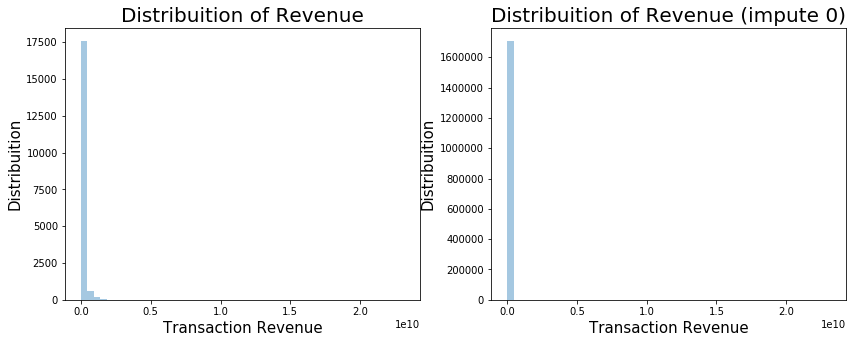

In [17]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
ax = sns.distplot(df_train['totals.transactionRevenue'].dropna(), bins=50, kde=False)
ax.set_xlabel('Transaction Revenue', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of Revenue", fontsize=20) 

plt.subplot(1,2,2)
ax = sns.distplot(df_train['totals.transactionRevenue'].fillna(0.0), bins=50, kde=False)
ax.set_xlabel('Transaction Revenue', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of Revenue (impute 0)", fontsize=20) 

plt.show()


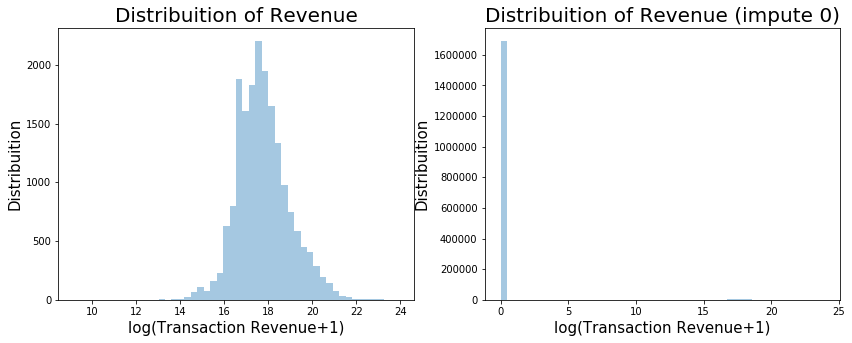

In [18]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
ax = sns.distplot(np.log1p(df_train['totals.transactionRevenue'].dropna()), bins=50, kde=False)
ax.set_xlabel('log(Transaction Revenue+1)', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of Revenue", fontsize=20) 

plt.subplot(1,2,2)
ax = sns.distplot(np.log1p(df_train['totals.transactionRevenue'].fillna(0.0)), bins=50, kde=False)
ax.set_xlabel('log(Transaction Revenue+1)', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of Revenue (impute 0)", fontsize=20) 

plt.show()

Define some functions for visualization:

In [22]:
def plot_float(df_train, name_x, name_y, logscale=True):
    # plot the float/int numbers
    df_train_temp = df_train.copy()
    
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    if(logscale):
        ax = sns.distplot(np.log1p(df_train_temp[name_x].dropna()), bins=50, kde=False)
        ax.set_xlabel('log('+name_x+'+1)', fontsize=15)     
    else:
        ax = sns.distplot(df_train_temp[name_x].dropna(), bins=50, kde=False)
        ax.set_xlabel(name_x, fontsize=15)     
     
    ax.set_ylabel('Distribuition', fontsize=15) 
    ax.set_title('Distribuition of '+name_x, fontsize=20) 

    df_train_temp.fillna({name_x: -0.5, name_y: -1e9},inplace=True)
    
    plt.subplot(1,2,2)
    plt.scatter(range(df_train_temp.shape[0]), 
            df_train_temp.sort_values(by=[name_x])[name_y].values)
    plt.xlabel('Index sorted by '+name_x, fontsize=15) 
    plt.ylabel(name_y+'value', fontsize=15) 
    plt.title('Distribution of '+name_y, fontsize=20) 

    plt.show()


def mergeCategory(df_col, threshold):
    # merge the levels in this catergorical features with a frequency smaller than a input threshold
    threshold = threshold * df_col.shape[0]
    
    df_count = df_col.value_counts()   
    if np.min(df_count) < threshold:
        to_merge = df_count[df_count <= threshold].index
        df_col.replace(to_merge, 'Other', inplace=True)
    
    return df_col


def plot_category(df_train, name_x, name_y, threshold=0.01):
    # plot the categorical data in a pie chart
    train_temp = df_train.copy()

    mrg_col = mergeCategory(train_temp[name_x], threshold)
    train_temp[name_x] = mrg_col

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    df_count = train_temp[name_x].value_counts()   
    labels = df_count.index
    counts = df_count
    cmap = plt.get_cmap('Spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    plt.pie(counts, labels=labels, colors=colors)
    plt.axis('equal')
    title = "%s" % (name_x)
    plt.title(title, fontsize=20) 
    
    train_temp.dropna(subset=[name_y], inplace=True)
    train_temp[name_y] = np.log1p(train_temp[name_y])

    plt.subplot(1,2,2)
    g1 = sns.boxplot(
        x=name_x,
        y=name_y,
        data=train_temp)
    
    g1.set_xlabel(name_x, fontsize=15) 
    g1.set_xticklabels(g1.get_xticklabels(), rotation=40, ha="right")
    g1.set_ylabel(name_y, fontsize=15) 

    plt.show()
    
    
def perent_nan(df, col_x, col_y):
    # check the percent of nan in target (col_y) for the given feature (col_x) that has nan as well
    
    idx_x_nan = df_train[col_x].isnull()
    idx_y_nan = df_train[idx_x_nan][col_y].isnull()
        
    num_nan_x =df_train[idx_x_nan][col_y][idx_y_nan].shape[0]
    num_nan_y_in_nan_x =df_train[idx_x_nan].shape[0]
    
    print(num_nan_x)
    print(num_nan_y_in_nan_x)
    
    print('Percentage of nan target in this feature:')
    print(100*num_nan_x /num_nan_y_in_nan_x)

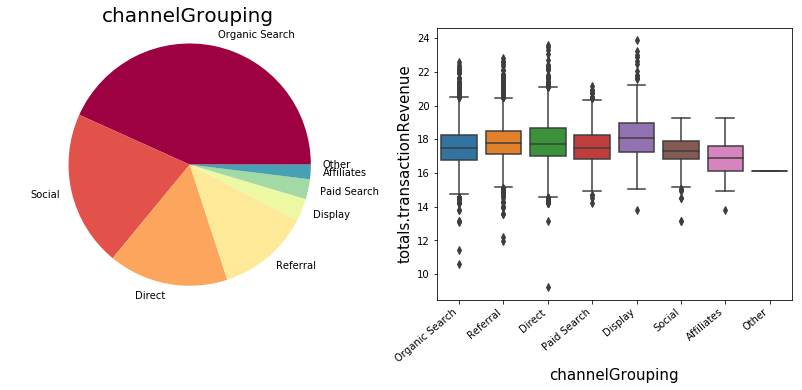

In [20]:
plot_category(df_train, 'channelGrouping', 'totals.transactionRevenue')

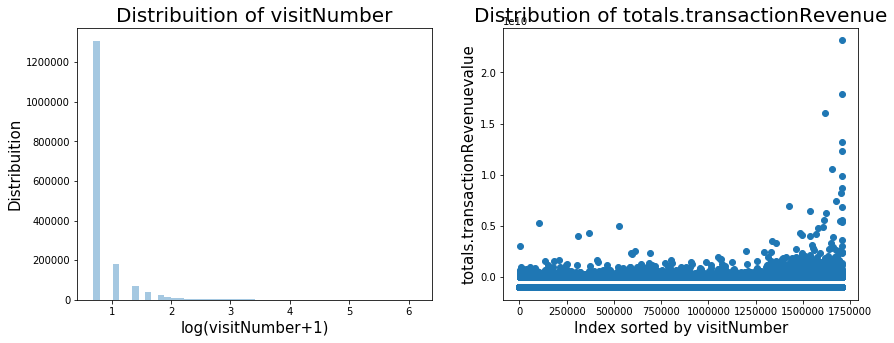

In [21]:
plot_float(df_train, 'visitNumber', 'totals.transactionRevenue')

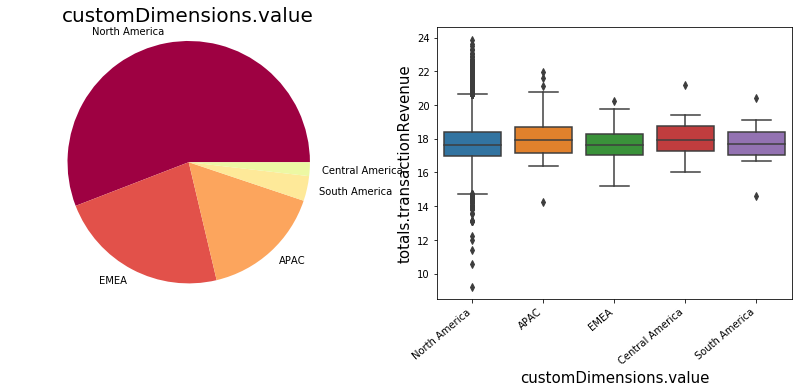

In [23]:
plot_category(df_train, 'customDimensions.value', 'totals.transactionRevenue')

In [24]:
perent_nan(df_train, 'customDimensions.value', 'totals.transactionRevenue')

333002
333235
Percentage of nan target in this feature:
99.93007937341515


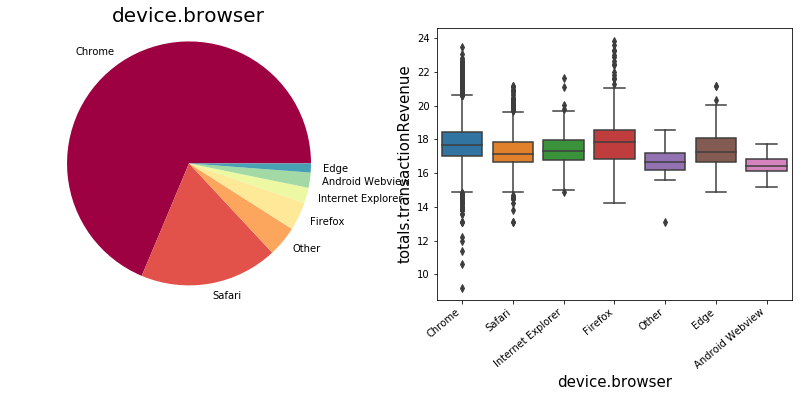

In [25]:
plot_category(df_train, 'device.browser', 'totals.transactionRevenue')

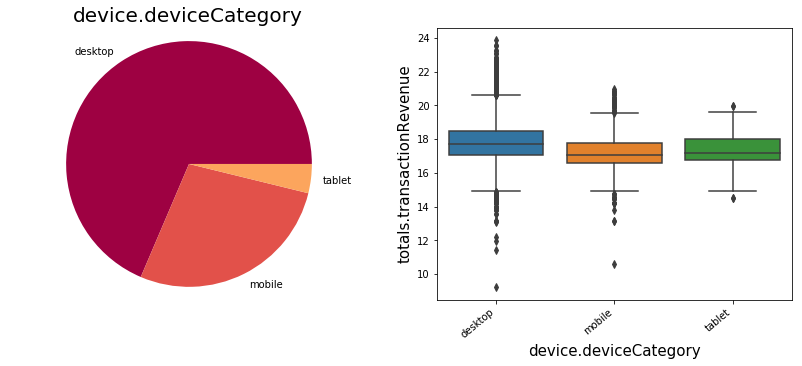

In [26]:
plot_category(df_train, 'device.deviceCategory', 'totals.transactionRevenue')

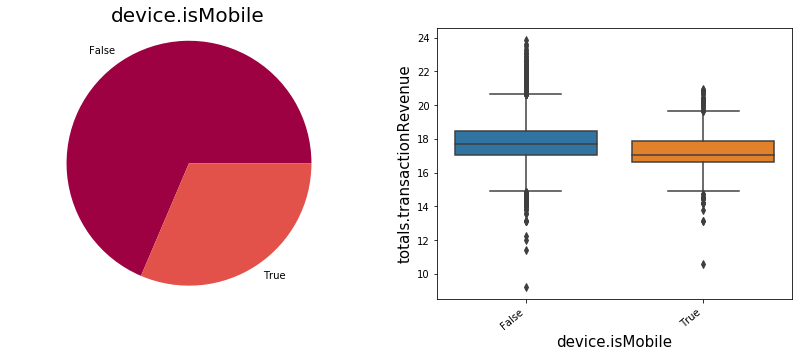

In [27]:
plot_category(df_train, 'device.isMobile', 'totals.transactionRevenue')

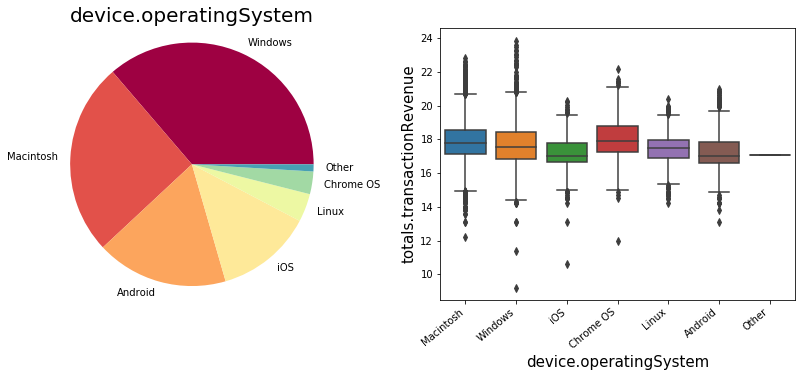

In [28]:
plot_category(df_train, 'device.operatingSystem', 'totals.transactionRevenue')

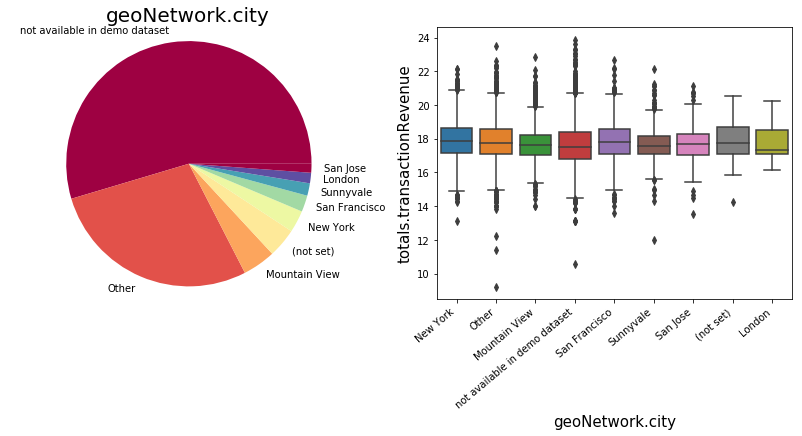

In [29]:
plot_category(df_train, 'geoNetwork.city', 'totals.transactionRevenue')

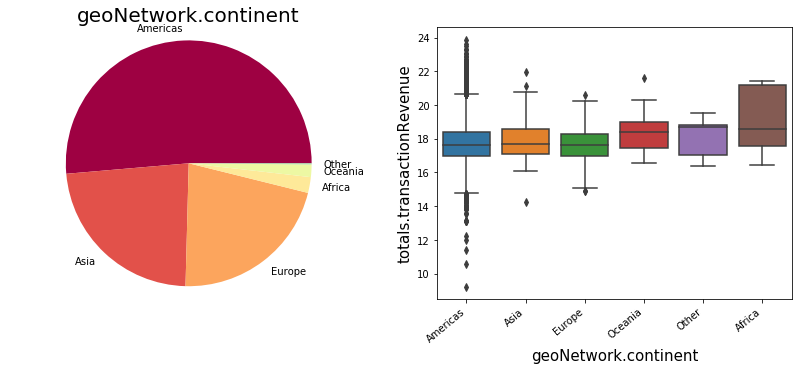

In [30]:
plot_category(df_train, 'geoNetwork.continent', 'totals.transactionRevenue')

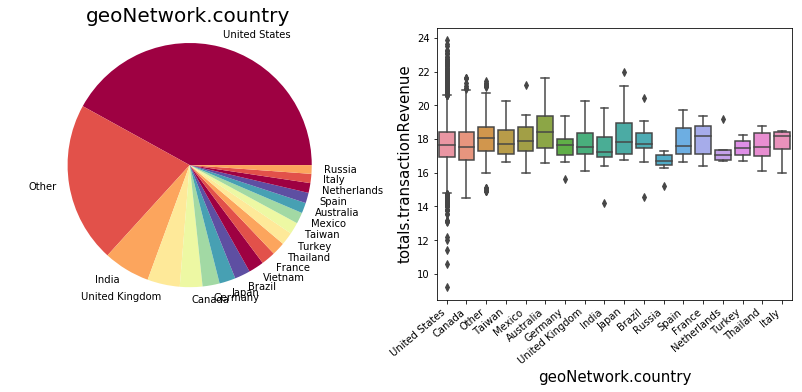

In [31]:
plot_category(df_train, 'geoNetwork.country', 'totals.transactionRevenue')

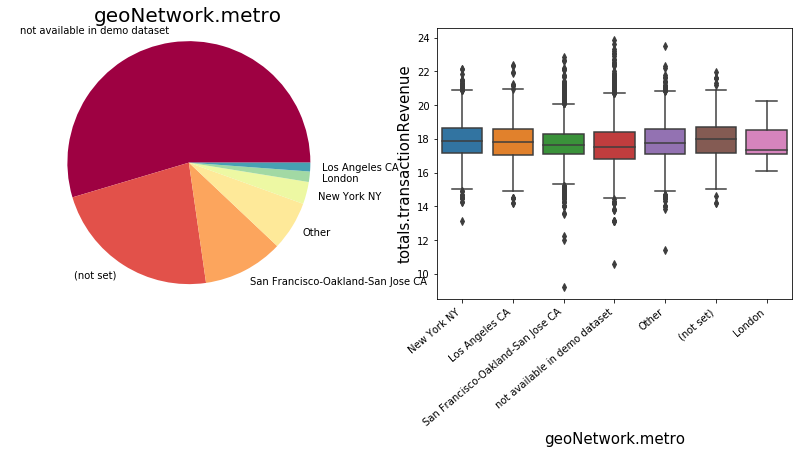

In [32]:
plot_category(df_train, 'geoNetwork.metro', 'totals.transactionRevenue')

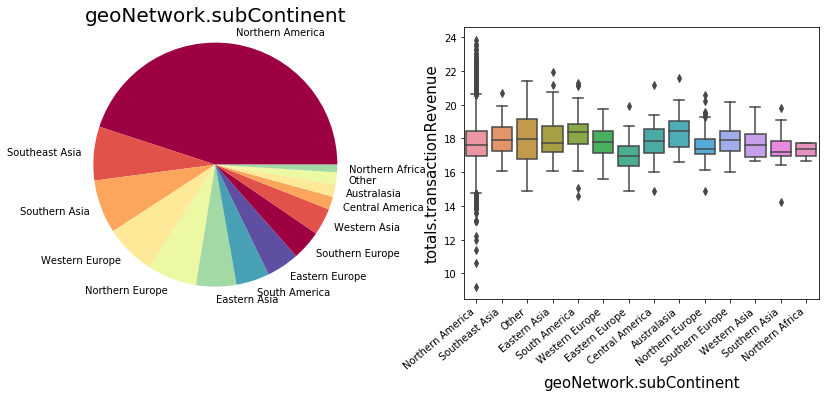

In [33]:
plot_category(df_train, 'geoNetwork.subContinent', 'totals.transactionRevenue')

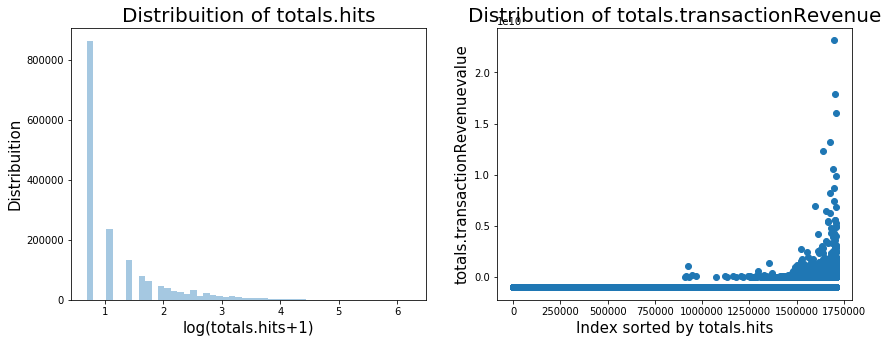

In [34]:
plot_float(df_train, 'totals.hits', 'totals.transactionRevenue')

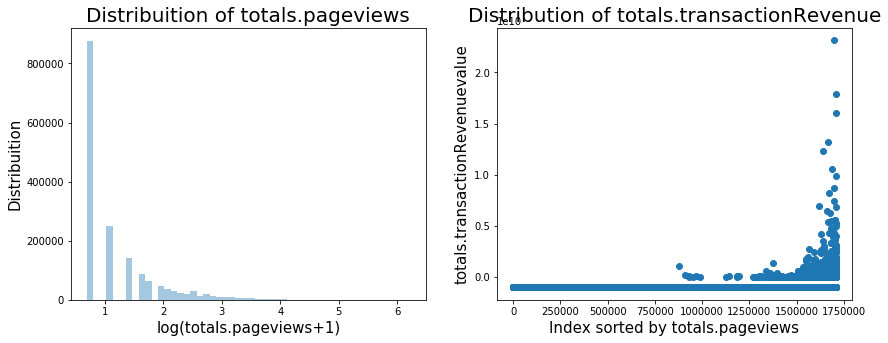

In [35]:
plot_float(df_train, 'totals.pageviews', 'totals.transactionRevenue')

In [36]:
perent_nan(df_train, 'totals.pageviews', 'totals.transactionRevenue')

239
239
Percentage of nan target in this feature:
100.0


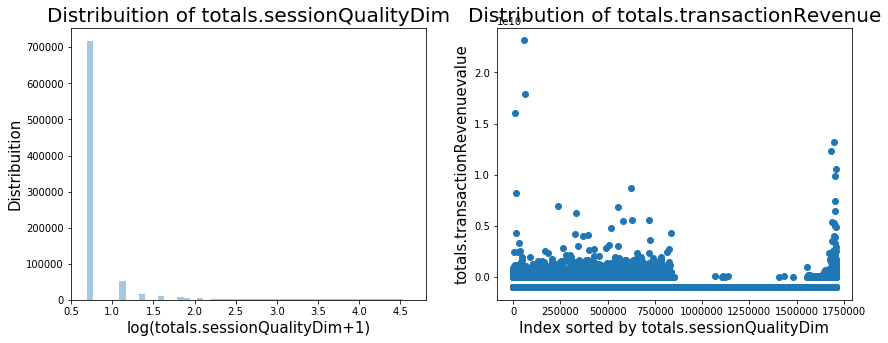

In [37]:
plot_float(df_train, 'totals.sessionQualityDim', 'totals.transactionRevenue')

In [38]:
perent_nan(df_train, 'totals.sessionQualityDim', 'totals.transactionRevenue')

824809
835274
Percentage of nan target in this feature:
98.74711771227166


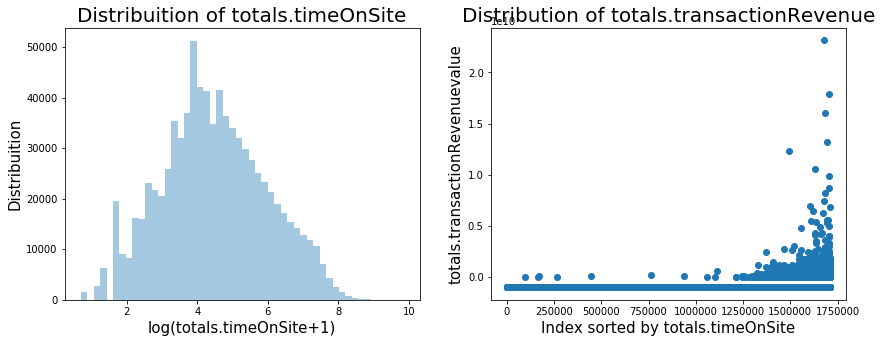

In [39]:
plot_float(df_train, 'totals.timeOnSite', 'totals.transactionRevenue')

In [40]:
perent_nan(df_train, 'totals.timeOnSite', 'totals.transactionRevenue')

874288
874294
Percentage of nan target in this feature:
99.99931373199405


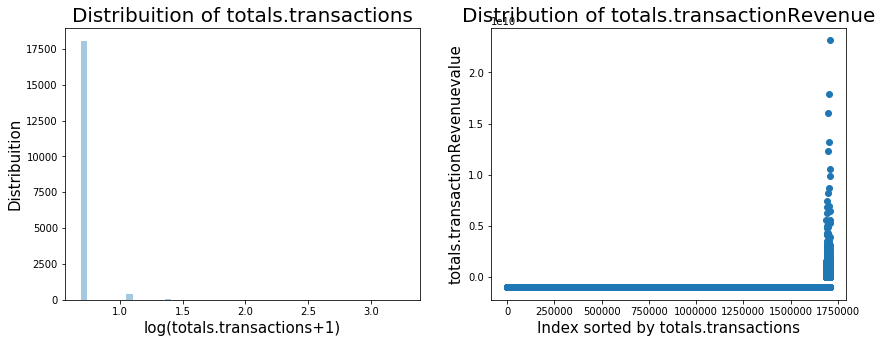

In [41]:
plot_float(df_train, 'totals.transactions', 'totals.transactionRevenue')

In [42]:
perent_nan(df_train, 'totals.transactions', 'totals.transactionRevenue')

1689778
1689778
Percentage of nan target in this feature:
100.0


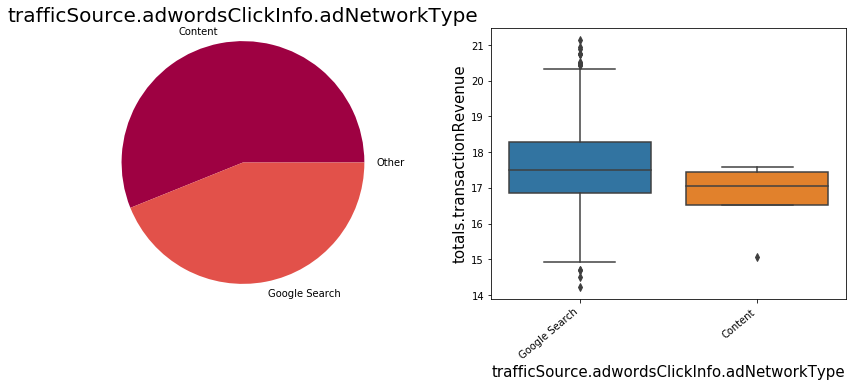

In [43]:
plot_category(df_train, 'trafficSource.adwordsClickInfo.adNetworkType', 'totals.transactionRevenue')

In [44]:
perent_nan(df_train, 'trafficSource.adwordsClickInfo.adNetworkType', 'totals.transactionRevenue')

1615210
1633063
Percentage of nan target in this feature:
98.90677824431758


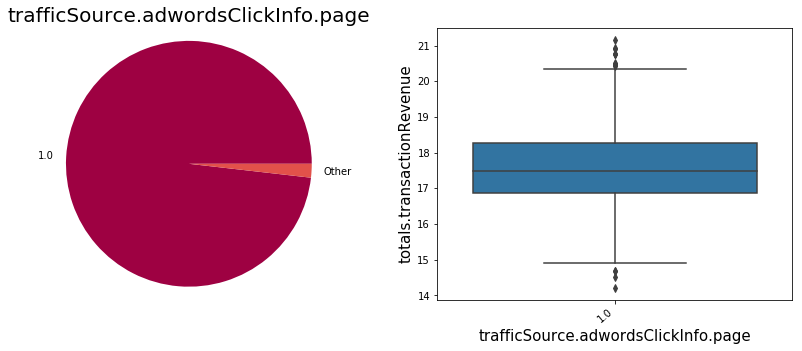

In [45]:
plot_category(df_train, 'trafficSource.adwordsClickInfo.page', 'totals.transactionRevenue')

In [46]:
perent_nan(df_train, 'trafficSource.adwordsClickInfo.page', 'totals.transactionRevenue')

1615210
1633063
Percentage of nan target in this feature:
98.90677824431758


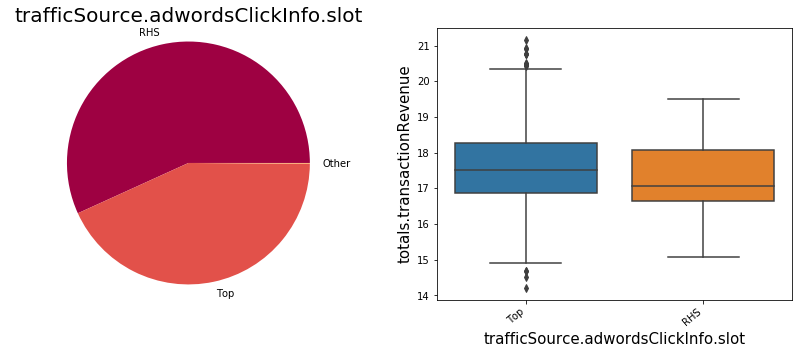

In [47]:
plot_category(df_train, 'trafficSource.adwordsClickInfo.slot', 'totals.transactionRevenue')

In [48]:
perent_nan(df_train, 'trafficSource.adwordsClickInfo.slot', 'totals.transactionRevenue')

1615210
1633063
Percentage of nan target in this feature:
98.90677824431758


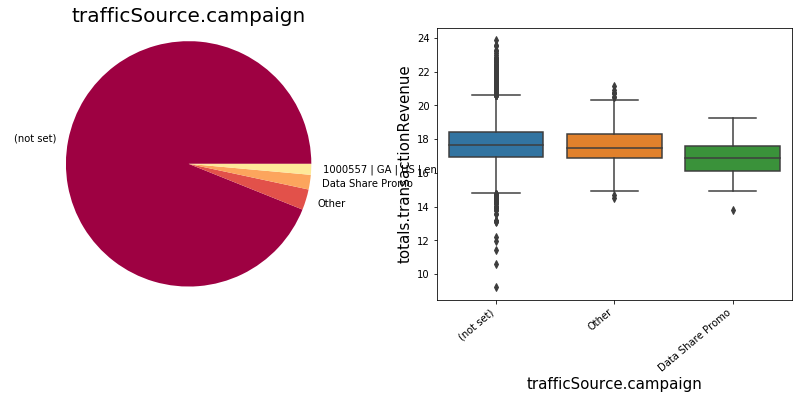

In [49]:
plot_category(df_train, 'trafficSource.campaign', 'totals.transactionRevenue')

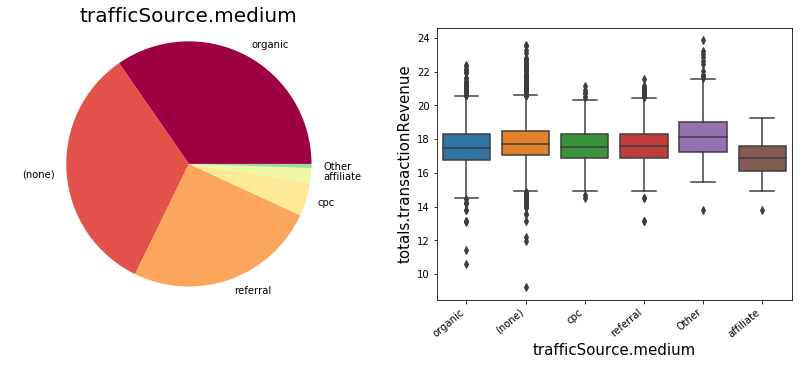

In [50]:
plot_category(df_train, 'trafficSource.medium', 'totals.transactionRevenue')

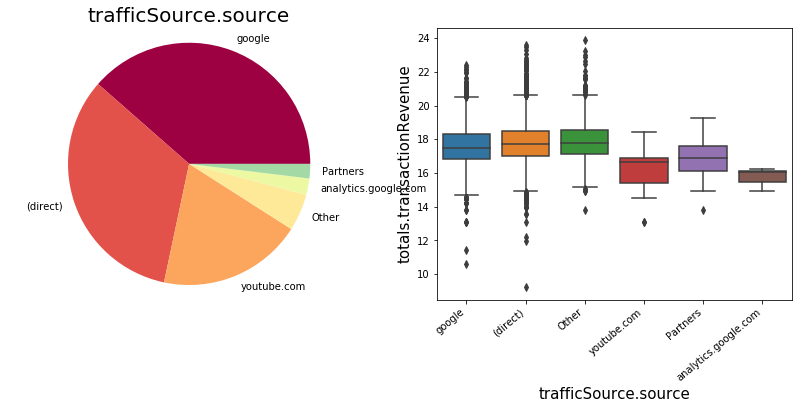

In [52]:
plot_category(df_train, 'trafficSource.source', 'totals.transactionRevenue')

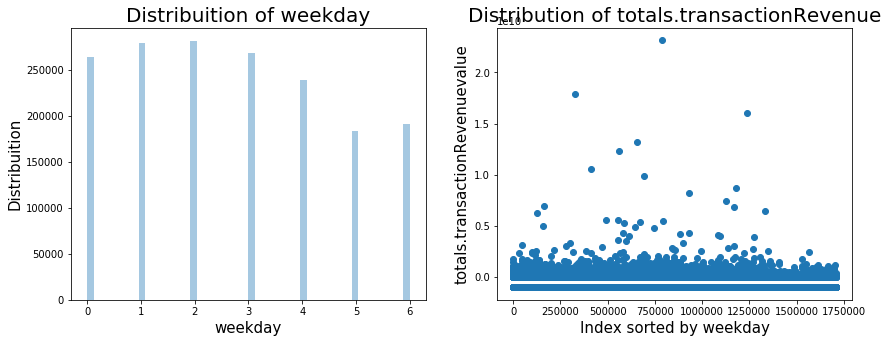

In [53]:
plot_float(df_train, 'weekday', 'totals.transactionRevenue', logscale=False)

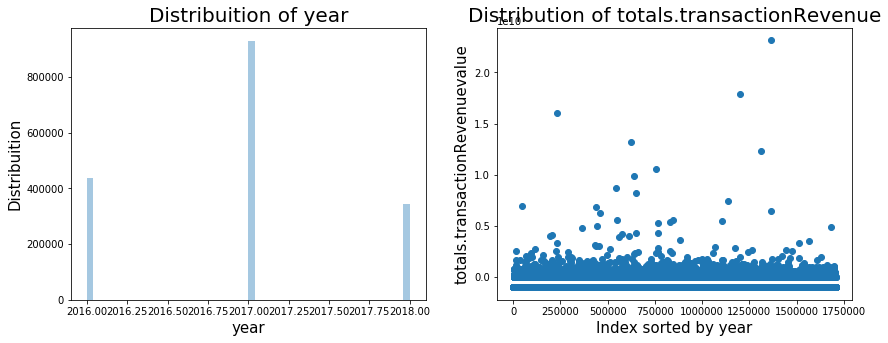

In [54]:
plot_float(df_train, 'year', 'totals.transactionRevenue', logscale=False)

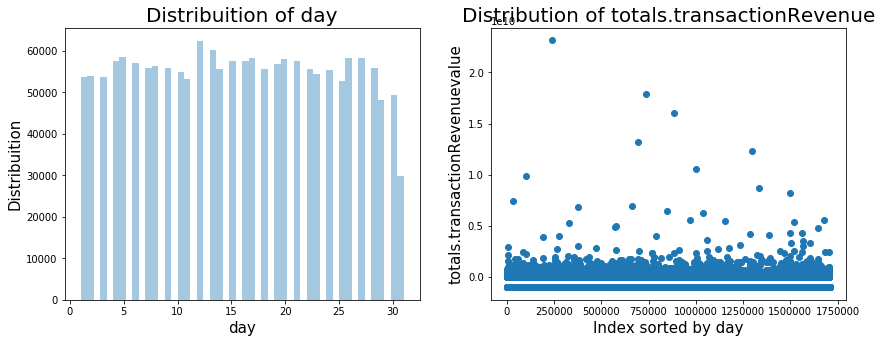

In [55]:
plot_float(df_train, 'day', 'totals.transactionRevenue', logscale=False)

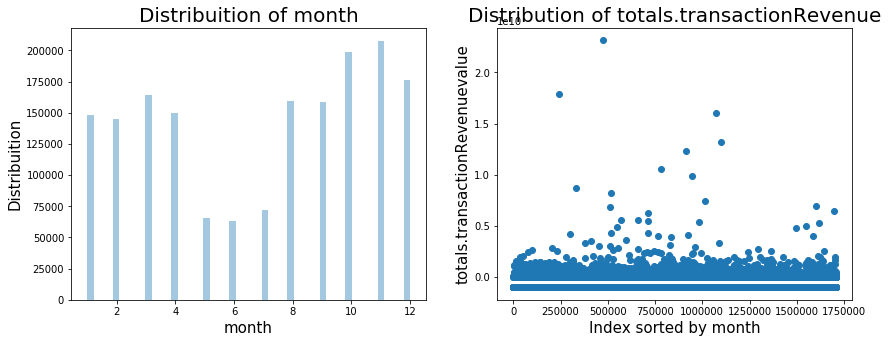

In [56]:
plot_float(df_train, 'month', 'totals.transactionRevenue', logscale=False)